# 📊 KTT Project Report

**Author:** Mengmeng Li <br>
**Date:** May 20, 2025

---

## 📌 1. Executive Summary

This report demonstrates the use of statistical models to construct a profitable portfolio with consistent risk-adjusted returns, based on the provided dataset and information. The portfolio performance of the constructed strategy is presented, and potential future improvements are discussed at the end of the report.

**Key Steps:**

> - Data Overview
> - Feature Engineering
> - Portfolio Construction and Performance Analysis
> - Future Improvements

---


## 📂 2. Data Overview

### 2.1 Dataset Summary

Three different datasets were provided for analysis. A "collect and cache" process was completed beforehand, with the key steps outlined below:

- **File Consolidation and Formatting** <br>
    Files for each dataset type were appended and consistently formatted across columns.
    *(Functions used: `collect_and_cache_data()` and `format_data()` in `util_func.py`)* <br>
    **Note:** This process only needs to be executed once. Flat files are saved for efficient reuse. Feature data are stored as daily files marked by 'data_date' to enhance processing speed—particularly important given the limitations of a personal laptop.

- **Consistent Time Periods** <br>
    All three datasets ranges from 2010-01-04 to 2017-12-29: 2013 trading dates in total.
    While some feature dataset includes a few mor dates (not trading dates), extra data are minor and can be safely ignored.

- **Data Handling** <br>
    Some features contain multiple values per security per trading day.
    To simplify the analysis, the mean is calculated to ensure a single entry per security per day.

<br>

| Dataset              | Description                                                                                     | Range                    | Columns        |
|----------------------|-------------------------------------------------------------------------------------------------|--------------------------|----------------|
| `Security ref. data` | Daily information such as close price, return, and eligibility to trade on a given date         | 2010-01-04 to 2017-12-29 | 6 variables    |
| `Feature data`       | Primary dataset used to construct features (referred to as "feature data" in this report)       | Same as above            | 11 features    |
| `Risk factors`       | Risk factor exposure scores for each security                                                   | Same as above            | 6 risk factors |

<br>

### 2.2 Data Findings

#### 2.2.1 Security Reference Data

<br>

1. **`in_trading_universe` Analysis:**
    The table below summarizes the size of the eligible trading universe over the full time horizon. Most features are constructed only using securities in the trading universe. Further details will be provided in later sections.

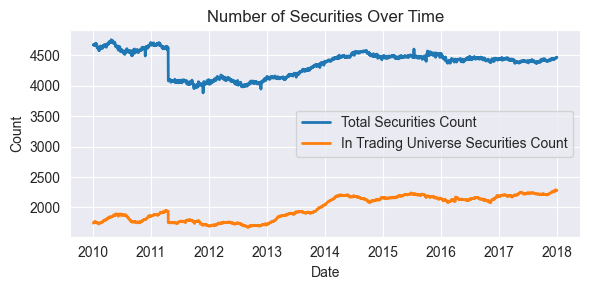

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

ref_df = pd.read_pickle('data/ref_df.pkl.gz')
ref_df['in_trading_universe_flag'] = ref_df['in_trading_universe'].map({'Y': 1, 'N': 0})
df_summary = ref_df[['data_date','security_id', 'in_trading_universe_flag']].groupby('data_date').agg(
    total_securities=('security_id', 'nunique'),
    in_universe_count=('in_trading_universe_flag', 'sum')
).reset_index()

plt.figure(figsize=(6, 3))
plt.plot(df_summary['data_date'], df_summary['total_securities'], label='Total Securities Count', linewidth=2)
plt.plot(df_summary['data_date'], df_summary['in_universe_count'], label='In Trading Universe Securities Count', linewidth=2)

plt.title('Number of Securities Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2. **`group_id` Analysis:**
    This column categorizes securities into peer groups, allowing for industry-level analysis. If features need to be constructed at the group level (i.e., based on securities within the same industry), the coverage within each group becomes important—there must be a sufficient number of securities in each group to ensure meaningful results.

    - The 1st table below summarizes the number of groups in each level.
    - The 2nd table below presents the average number of securities per trading day for each group at group level 1.

In [26]:
ref_df['grp_l_1'] = ref_df['group_id'].str[:2]
ref_df['grp_l_2'] = ref_df['group_id'].str[:4]
ref_df['grp_l_3'] = ref_df['group_id'].str[:6]
# ref_df[ref_df['in_trading_universe']=='Y'][['security_id', 'group_level_1', 'group_level_2', 'group_level_3']].describe()
group_cols=['group_id', 'grp_l_1', 'grp_l_2', 'grp_l_3']
group_counts = {f"# of {col}": ref_df[col].nunique() for col in group_cols}
summary_table = pd.DataFrame([group_counts])
summary_table

,# of group_id,# of grp_l_1,# of grp_l_2,# of grp_l_3
0,176,11,25,72


In [28]:
grouped = ref_df.groupby(['grp_l_1', 'data_date'])['security_id'].nunique().reset_index(name='security_count')
avg_sec_count_per_group = grouped.groupby('grp_l_1')['security_count'].mean().round(0).astype(int).reset_index(name='avg#_sec_in_grp_l_1')

grouped_univ = ref_df[ref_df['in_trading_universe']=='Y'].groupby(['grp_l_1', 'data_date'])['security_id'].nunique().reset_index(name='security_count')
avg_sec_count_per_group_l1_in_trade_uni = grouped_univ.groupby('grp_l_1')['security_count'].mean().round(0).astype(int).reset_index(name='avg#_tradable_sec_in_grp_l_1')['avg#_tradable_sec_in_grp_l_1']

pd.concat([avg_sec_count_per_group, avg_sec_count_per_group_l1_in_trade_uni], axis=1)

,grp_l_1,avg#_sec_in_grp_l_1,avg#_tradable_sec_in_grp_l_1
0,10,271,156
1,15,260,137
2,20,563,256
3,25,587,301
4,30,179,87
5,35,622,236
6,40,908,352
7,45,754,328
8,50,79,36
9,55,110,74


#### 2.2.2 Feature Data

The feature data can be broadly categorized into two types:

- **Event-Driven Features (Type 1: d1–d7)** <br>
  These are typically updated quarterly. For example, earnings-related metrics fall into this category.
  On a typical trading day, fewer than 200 securities (in trading universe) have available (non-NaN) values for these features.

- **Non-Event-Driven Features (Type 2: d8–d11)** <br>
  These features are updated daily and are available for most securities in the universe.
  On each trading day, around 2,000 securities have valid observations for these features.


Type 2 features are available almost daily for most securities, while Type 1 features are typically available on a **quarterly basis**, often tied to events such as earnings announcements or financial disclosures.

The graph below illustrates a representative Type 1 feature (d1), showing how many securities have non-missing values across the full sample period. Similar patterns hold for all d1–d7 features, whereas d8–d11 are consistently populated for the majority of the security universe.
This classification is useful for understanding data sparsity and designing appropriate feature engineering strategies.



In [11]:
import altair as alt

count_d1 = fea_raw[['data_date', 'd1']].copy().groupby('data_date')['d1'].apply(lambda x: x.notna().sum()).reset_index(name='non_nan_count')
chart = alt.Chart(count_d1).mark_line(point=True).encode(
    x='data_date:T',
    y='non_nan_count:Q'
).properties(
    title='Non-NaN Value Counts for Feature d1 per day (include non tradable sec.)',
    width=800,    # Width in pixels
    height=200
)

chart

alt.Chart(...)

### 2.3. How to Use the Data to Build a Strategy

#### 📘 Classical Framework

In traditional systematic trading strategies, portfolio construction typically follows a well-defined pipeline consisting of three main steps:

1. **Feature Engineering & Alpha Modeling**
   Predictive features—such as fundamentals, technical indicators, or macroeconomic variables—are used to estimate expected asset returns. This process is often referred to as *alpha modeling*.

2. **Risk Modeling**
   A **variance-covariance matrix** is estimated to capture the volatility and correlations among assets. Common approaches include sample covariance, shrinkage estimators (e.g., **Ledoit-Wolf**), or factor-based risk models.

3. **Portfolio Optimization**
   Expected returns and risk estimates are then combined using **mean-variance optimization (MVO)**, introduced by **Markowitz (1952)**, to determine optimal portfolio weights by balancing expected return and risk.
   In practice, constraints such as leverage limits, sector exposure, and turnover caps are applied to ensure feasibility.

This classical framework is extensively documented in foundational texts such as
*Active Portfolio Management* by Grinold and Kahn (1999), and
*Quantitative Equity Portfolio Management* by Qian, Hua, and Sorensen (2007).
It remains a cornerstone of many quantitative investment strategies in both academia and industry.

<br>

#### ⚙️ Approach in This Project

Given practical constraints—including time, limited data availability, and computational resources—I adopted a **simplified approach** instead of the full classical framework.

In this method, **feature values are directly used as portfolio holding signals**, under the assumption that higher feature scores correspond to stronger expected returns. This approach avoids explicit return forecasting and optimization, enabling faster iteration and reduced model complexity.

While this method trades off some theoretical precision, it offers a practical and intuitive baseline to assess the effectiveness of individual features in capturing cross-sectional return patterns. It also serves as a useful starting point for identifying promising features that may warrant more sophisticated modeling in future work.

---

## 🧪 3. Methodology

### 3.1 Feature Construction

Four main methodologies are adopted to construct features from the raw data, details are illustrated as below.

---

#### **3.1.1 Basic Feature Construction**
All 11 raw features are transformed through ranking plus z-scores and normalization using gross market value (GMV).

At each trading date \( t \), for all \( n \) securities in the trading universe (i.e., `data_date == t`, `in_trading_universe == Y`):

- Retrieve the raw feature value at \( t - 1 \):
  x_i = (value of security i at t-1)

- Rank the values and convert to z-scores:
  z_i = (x_i_rank - mu)/sigma

- Normalize by the gross market value GMV (sum of absolute z-scores):
  f_basic_i = z_i / z_i.abs().sum()

This process is applied to each of the 11 features individually, resulting in 11 **basic features**.
*Function used: `build_basic_fea()` in `util_func.py`*

---

#### **3.1.2 Change Feature Construction**

Change-based features are calculated to capture trends or shifts in the raw signals over time. Methodology differs for event-driven and non-event-driven features.

##### 📌 *Event-Driven Change Features* (d1–d7)
Event-driven feature are available for securities quarterly. At each trading date \( t \), for all \( n \) securities in the trading universe (i.e., `data_date == t`, `in_trading_universe == Y`), I calculate:

- Retrieve the raw feature value at \( t - 1 \) as current quarter value:
  Q_0 = (value of security i at t-1)
  similarly, I will retrieve past 4 quarter values: e.g., Q_lag1 = (value of security i at one quarter prior to t-1)

- Normalized **Quarter-over-Quarter Change Percent**: <br>
  f_dif_Q0_Q_lag1: (Q_0 - Q_lag1)/(|Q_0| + |Q_lag1|)

- Normalized **Year-over-Year Change Percent**: <br>
  f_dif_Q0_Q_lag4: (Q_0 - Q_lag4)/(|Q_0| + |Q_lag4|)

- Normalized **Change from 4-Quarter Average**: <br>
  f_dif_Q0_Q_Avg_lag1_4: (Q_0 - Q_Avg_lag1_4)/(|Q_0| + |Q_Avg_lag1_4|)

- For above 3 computed changes, normalize them to be long/short market neutral: <br>
  f_normalized_i = f_pos *0.5 /f_pos.abs().sum() if f_dif_i is positive else: f_neg*0.5 /f_neg.abs().sum()

This process is applied to each of the 7 features individually, yielding 7*3 = 21 new **change features**.
*Function used: `build_dif_fea_type1()` in `util_func.py`*
<br>

##### 📌 *Non-Event-Driven Change Features* (d8–d11)
For each of the 4 non-event-driven features, 6 variations were constructed using combinations of averaging periods:

- At each trading date \( t \), for all \( n \) securities in the trading universe (i.e., `data_date == t`, `in_trading_universe == Y`), calculate:
  - Let \( A_AvgX \) = average of last \( X \) days (e.g., 5 or 21) from t-1 (the most recent available date)
  - Let \( B_lagY_AvgX \) = average of same window starting \( Y \) days ago (e.g., 21, 63, 126)

- Computer the change percentage as: <br>
  f_diff_type_2 = ( A_AvgX - B_lagY_AvgX )/ |B_lagY_AvgX|

- Apply `rank → z-score → GMV normalization` across all securities on date \( t \) to obtain the final feature.


This process is applied to each of the 4 features, 6 combinations per feature were computed, yielding 4*6 = 24 new **change features**.
*Function used: `build_dif_fea_type2()` in `util_func.py`*

| **Example**          | **Description**                                                                                                                                                                    |
|----------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `d8_shift21_avg5`    | For raw feature `d8`, compute A: 5-day avg from \( t-5 \) to \( t-1 \) and B: 5-day avg from \( t-26 \) to \( t-22 \). Calculate (A-B)/abs(B), then rank zscore divided GMV        |
| `d11_shift126_avg21` | For raw feature `d11`, compute A: 21-day avg from \( t-21 \) to \( t-1 \) and B: 21-day avg from \( t-147 \) to \( t-127 \). Calculate (A-B)/abs(B), then rank zscore divided GMV  |

---

<br>

<br>

### Group-Level Features: Peer-Spread and Industry-Neutral Signals

Industry or sector groupings (`group_id`) are essential for constructing more targeted and interpretable features. These groupings capture **shared behavioral patterns**, **structural characteristics**, and **business cycle sensitivities** among similar securities.

By leveraging group-level information, we can design features that are either:

- **Peer-Spread**: Incorporating comparisons within a group to extract **relative strength or weakness**
- **Industry-Neutral**: Adjusting features to remove industry-specific biases and enhance cross-sector comparability

##### Why Use Group-Level Information?

- **🔍 Improve Comparability**
  Metrics like valuation ratios, profitability, or growth can vary dramatically across sectors. Comparing them across unrelated industries may lead to misleading signals.

- **🎯 Avoid Sector Bias**
  Certain sectors might dominate raw features simply due to structural advantages (e.g., tech may always have higher R&D expenses). Without adjustment, these sectors could be overrepresented in signals.

- **📊 Enhance Relative Insight**
  Peer-based signals help identify which securities are **outperforming or underperforming their own industry**, which is often more meaningful than absolute values.

---

#### 3.1.3 Peer Spread Feature Construction

This method captures **relative momentum** within a security’s industry by comparing it to its closest peers based on historical behavior.

At each trading date \( t \), for each security \( i \) in the trading universe:

1. **Peer Selection**
   - Identify all peers within the same industry group (`group_id` level 1), including **non-tradable securities**.
   - Compute **6-month rolling correlations** of daily return between security \( i \) and its peers.
   - Select the **top 5 most correlated peers** to form the **dynamic peer group**.
   - Peer selection is **refreshed daily** for simplicity, though in practice this could be done less frequently (e.g., monthly).

2. **Peer Spread Calculation**
   - For each peer \( j \) in the selected peer group, compute the **average peer return** over a lookback window of \( n \) days (e.g., \( n = 5, 10, 21, 63 \)): Peer_Avg_n_Return_t_i

   - Compute the **self-average return** for security \( i \) over the same window: Return_t_i

   - Calculate the **peer spread**: Peer_Avg_n_Return_t_i - Return_t_i/sqrt(5)  (normalized the variance by the number of peers)

3. **Normalization**
   - Apply `rank → z-score → GMV normalization` across all securities on date \( t \) to obtain the final feature.

##### Interpretation

This feature highlights **how a security is performing relative to its most similar peers**, providing a **context-aware signal** of relative strength. It’s particularly useful in reducing noise from cross-sector effects and surfacing performance anomalies within industries.

This process is applied purely used historical return data to construct 4 new **peer spread features**. *Function used: `build_peer_spread()` in `util_func.py`*

---

#### 3.1.4 Industry-Neutral Features

To remove sector-level biases and focus on **within-industry differentiation**, we construct **industry-neutral versions** of both the basic (all features) and change features (only for non-event-driven features: d8–d11).

Instead of applying the `rank → z-score → GMV` normalization across the entire universe, apply it **within each group**. Group level 1 is selected to ensure the sufficient security coverage within each group.

Total new features added:
- 11 (basic features group version)
- 4 × 6 = 24 (change features group version)
→ **35 industry-neutral features**
This process is embedded in the basic and feature construction for non-event-driver features, no additiontal function is needed.

| Example Features (Original) | Industry-Neutral Version         |
|-----------------------------|----------------------------------|
| `d8_basic`                  | `d8_basic_group1`                |
| `d8_diff_g2_shift21_avg5`   | `d8_diff_g2_shift21_avg5_group1` |


---


### 3.2 Feature Backtesting and Selection

After constructing a total of **95 features** in Section 3.1:

- 11 basic features
- 21 change-based features from event-driven data (Type 1)
- 24 change-based features from non-event-driven data (Type 2)
- 4 peer spread features
- 35 industry-neutral features

Next is to evaluate each feature’s **predictive power** through a simple **backtesting framework**. To assess the **signal quality** of each feature individually by testing how well it predicts future returns over a short-term investment horizon.

#### Backtesting Methodology

At each trading date \( t \), for each feature:

1. **Assume Feature Value as Security Holding**
   - Treat the feature value for each security as its position on day \( t \) given all feature values have been normalized.
   - Only include securities marked as **tradable** (`in_trading_universe = Y`) on that day.

2. **Forward-Looking Performance**
   - Collect each security’s **daily return** over the **next 15 trading days**
   - Construct the **feature-based portfolio return series** over this horizon

3. **Evaluate Performance via Sharpe Ratio**
   - Calculate the annualized **Sharpe Ratio** of the 15-day forward portfolio return




---

Backtesting is conducted over the training period from **2010 to 2015**, which represents approximately **75% of the total sample**. The remaining period, **2016 and 2017**, will later be used as a test set to evaluate the out-of-sample performance of the strategy.

The heatmap below presents the average **annualized Sharpe ratios** across the training period for all **95 constructed features**. For instance, the feature `'d10_pre21_Avg5_g1'` captures the **industry-neutralized change** in the `d10` variable between the current week's average and the average from roughly one month earlier.

In the heatmap:
- The **first column** indicates the feature’s predictive power for the **next day’s return** (i.e., t+1).
- The **second column** shows its predictive power for returns **two days ahead** (t+2), and so on.

Notably, the feature `'d10_pre21_Avg5_g1'` demonstrates its **strongest predictive power at t+3**, suggesting that its value **lagged by 2 days** is most effective in forecasting returns.

Based on such insights, the next step is to select the best-performing features along with their most predictive lags. These will be averaged to create **smoothed features**, which serve as the final input signals for strategy construction.



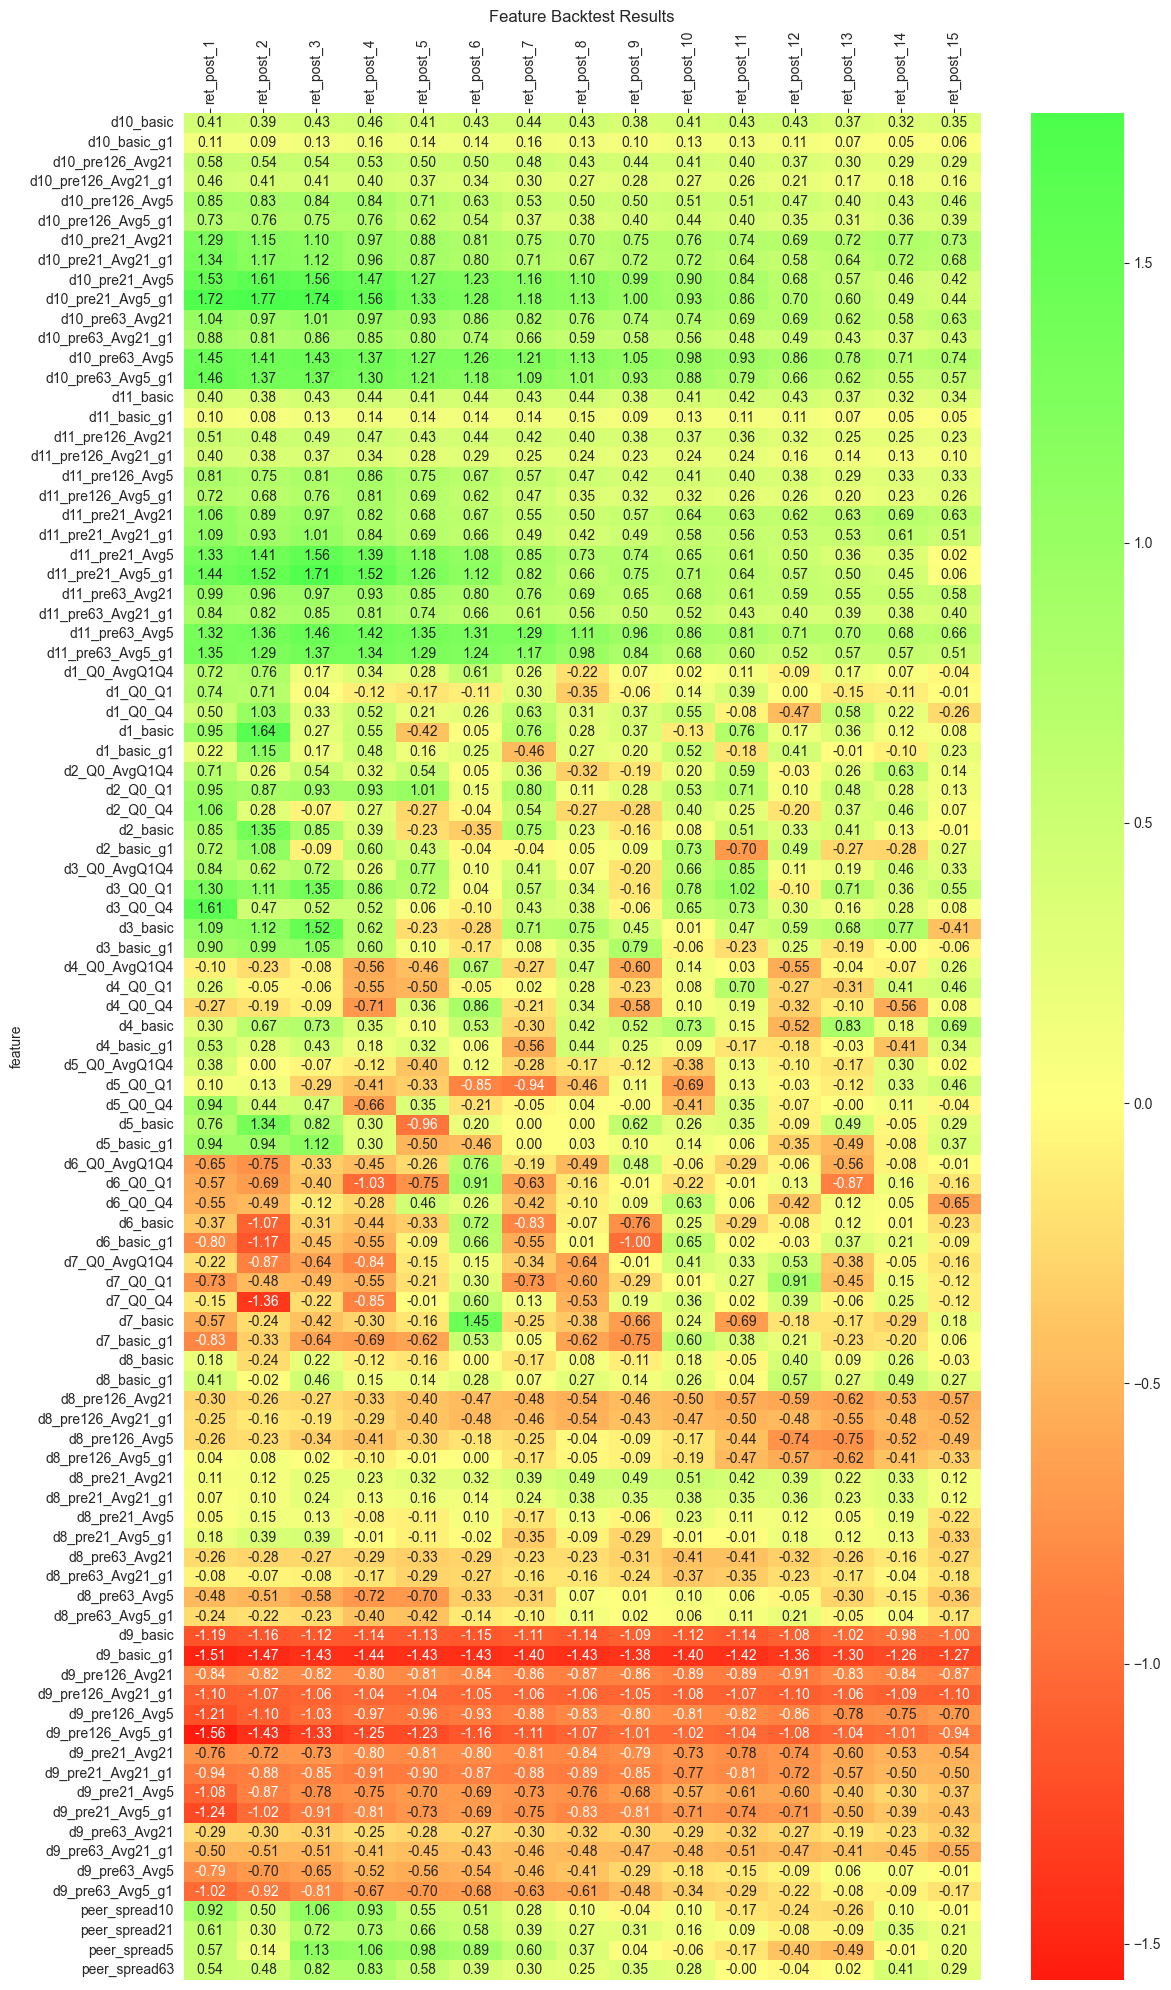

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Load and prepare data
df = pd.read_csv('data/backtest_res.csv')
df_matrix_ = df[
    (df['training_period'] == 'train') &
    (~df['feature'].isin(['group_level_1_basic_g1', 'group_level_1_g1']))
].copy().drop(columns=['training_period'])

df_matrix = df_matrix_.set_index('feature')

# Define a vivid red-white-green colormap
bright_rwg = LinearSegmentedColormap.from_list(
    "bright_rwg", ["#ff0000", "#ffff80", "#4dff4d"]
)

# Plot heatmap
plt.figure(figsize=(12, 20))
ax = sns.heatmap(df_matrix, annot=True, fmt=".2f", cmap=bright_rwg, center=0)

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Rotate x-axis labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.title("Feature Backtest Results")
plt.tight_layout()
plt.show()



### 3.3 Feature Smoothing

To enhance **signal stability** and reduce **short-term noise**, we apply feature smoothing techniques. While more sophisticated methods such as **exponential moving averages (EMA)** or **rolling means** are common, this project utilizes a **simple moving average** approach — averaging each feature with its own lagged values.

#### Feature Selection Logic:

Based on backtest performance, the selection of features for smoothing follows these criteria:

- **Positive Sharpe ratio features**:
  - If a feature shows an **annualized Sharpe ratio > 0.8**, it is selected along with its lagged versions (provided the lags also have Sharpe ratios > 0.8).
  - These are averaged to generate a smoothed version of the feature.

- **Negative Sharpe ratio features**:
  - If a feature has an **annualized Sharpe ratio < -1.0**, we further assess its consistency on backtest results for every individual year.

  - If the feature consistently underperforms across years, it and its qualifying lagged versions (also < -1.0) are selected to build **Negate smoothed signals**.

---

The graph below illustrates examples of features that consistently deliver large negative Sharpe ratios. For instance, `'d9_pre126_Avg5'` and `'d9_pre126_Avg5_g1'` exhibit strong and persistent negative performance across the entire training window. These features, along with their lagged versions, are considered for use in building inverse or short-side strategies.


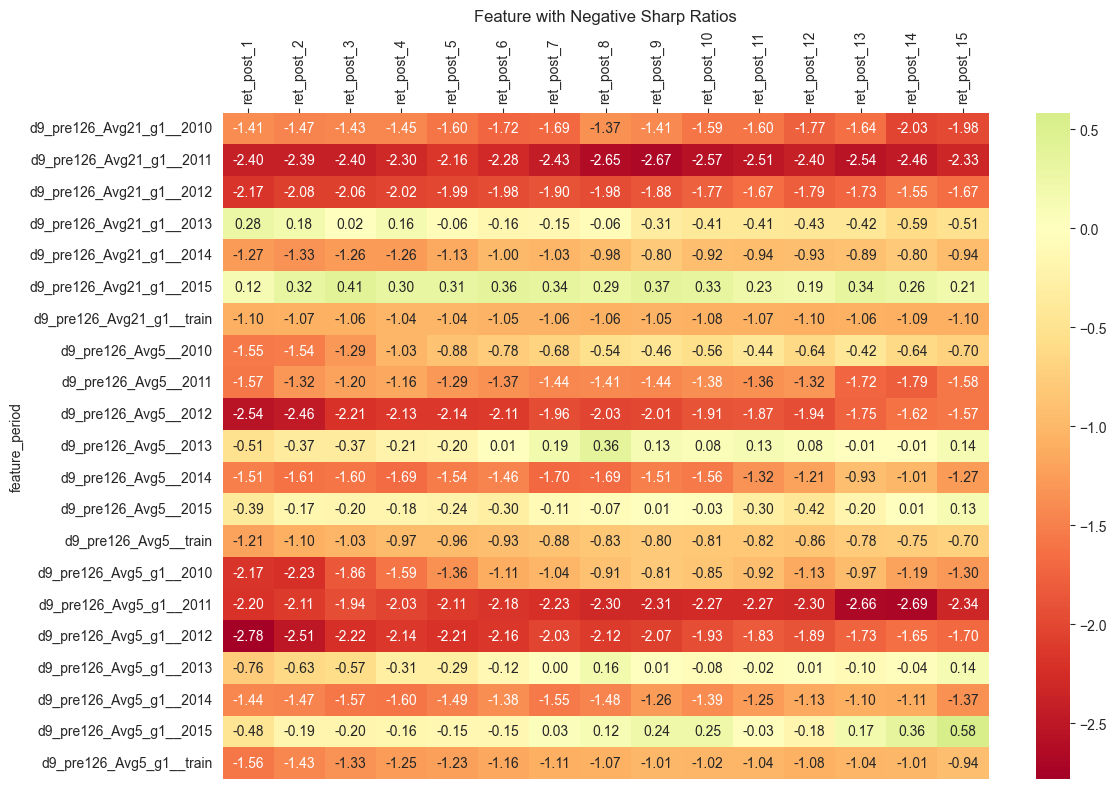

In [2]:
neg_ls = ['d9_pre126_Avg21_g1', 'd9_pre126_Avg5',  'd9_pre126_Avg5_g1']

df_matrix_neg = df[(df['feature'].isin(neg_ls))].copy()
df_matrix_neg['feature_period'] = df_matrix_neg['feature'] + '__' + df_matrix_neg['training_period']
df_matrix_neg_ = df_matrix_neg.drop(columns=['feature', 'training_period']).set_index('feature_period')

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_matrix_neg_, annot=True, fmt=".2f", cmap='RdYlGn', center=0)

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Rotate x-axis labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.title("Feature with Negative Sharp Ratios")
plt.tight_layout()
plt.show()


After conducting a thorough feature-by-feature review, the final selections are summarized in the configuration file **`feature_config.SMOOTH_CONFIG`**. This file specifies:

- Which features are selected.
- Specify which lags are used for smoothing.


The final **smoothed features** derived through this process will serve as the **core input signals** for portfolio construction. These refined signals aim to provide more stable and reliable indicators for portfolio decision-making. The methodology for constructing trading strategies based on these signals will be explained in detail in the **next section**.

*Function used: `build_smo_fea()` in `util_func.py`*

<br>

---

## 📈 4. Portfolio Construction

### 4.1 Feature Weight Selection

With the final set of smoothed features ready, I now assign weights to each component feature. These weights must sum to 1. The weighting process considers the following criteria for each component feature, calculated as:

- **Sharpe Ratio**:
    return_t.mean()/return_t.std

- **Return per Trade**:
    return_t/turnover_t

- **Turnover**:
  Defined as the absolute sum of position changes across all securities between time \( t-1 \) and \( t \).

The table below presents all component features along with the calculated parameters.

---

Based on these metrics, component features can be grouped by their **turnover**:

- **Faster features** (higher turnover) are grouped together.
- **Slower features** (lower turnover) are grouped separately.

Additionally, I analyzed the **correlations** among component features. Features with high positive or high negative correlation are grouped together to reflect their similar behavior.

The underlying methodology is to group features with similar characteristics and assign **equal weights within each group**. However, I **prioritize slower features** by assigning them **higher weights** than faster features.

The final weights are defined in the configuration file under:
`feature_config['feature_weight']`

Using these final weights, a **long/short normalization** is applied to construct the final strategy.


In [10]:
import pandas as pd

feature_criteria_df = pd.read_pickle('data/feature_criteria_df.pkl.gz')
feature_criteria_df.rename(columns={'ret_post_1': 'sharp ratio'}, inplace=True)
df = feature_criteria_df.sort_values(by='feature')
styled_df = df.style\
    .background_gradient(subset=['sharp ratio'], cmap='Greens')\
    .background_gradient(subset=['turnover'], cmap='Blues')\
    .background_gradient(subset=['return per trade'], cmap='Oranges')\
    .set_table_styles([
        {'selector': 'td', 'props': [('padding', '2px')]},
        {'selector': 'th', 'props': [('padding', '2px')]}
    ])\
    .format("{:.2f}")
styled_df

,sharp ratio,return per trade,turnover
feature,,,
d10_pre126_Avg5_smo_1_4,0.76,10.40,0.04
d10_pre21_Avg21_g1_smo_1_6,1.25,8.24,0.07
d10_pre21_Avg21_smo_1_6,1.11,8.55,0.06
d10_pre21_Avg5_g1_smo_1_11,1.59,8.29,0.08
d10_pre21_Avg5_smo_1_11,1.33,7.90,0.08
d10_pre63_Avg21_g1_smo_1_5,0.86,9.44,0.04
d10_pre63_Avg21_smo_1_7,0.81,11.65,0.04
d10_pre63_Avg5_g1_smo_1_8,1.28,10.96,0.05
d10_pre63_Avg5_smo_1_9,1.17,12.86,0.05


### 4.2 Exposure Analysis and Hedging through Risk Factors


A quick exposure calculation on given 6 risk factors was done and the exposure is relatively small. function
In Section 4.2, a final strategy (later refers as "final strategy before hedge" was obtained, now we need to run a quick analysis on the risk exposure on this strategy.

hhn Part 3. Portfolio Construction
1.	Decide on the weight
a.	Equal weight (robust for most cases)
b.	Select the weight based on, turnover(fast or slow),  edge (return by trade) and feature return correlation matrix (the goal is to maximize the benefit of the signal).
c.	Simulation could be done to calculate the weight, not necessarily robust or stable performance
2.	Check risk factor
3.	Generate plots
4.	Discuss impact of trading cost, rebalance frequency,
5.	Discuss future enhancement (multi core to increase the speed)



Used to hedge risk, run regression and then take the residual as the new feature to remove the risk factor component of the final feature.

<br>




### 4.3 Portfolio Performance








Performance Statistics are computed for both strategies: let's call them " The Strategy" and " Strategy with Hedge"
Below table presents their performance statistic over the time horizon.

In [20]:
import pandas as pd
import numpy as np

perf_mtrx = pd.read_pickle('data/strategy_performance.pkl.gz')
cols = ['gross_ret', 'net_ret', 'vol', 'sr', 'turnover_dly', 'hit','ret_per_trade']

df = perf_mtrx.reset_index().drop(columns=['level_1']).set_index('level_0')
format_dict = {
    col: "{:.2f}" for col in cols
}

styled_df = df.style\
    .set_table_styles([
        {'selector': 'td', 'props': [('padding', '2px')]},
        {'selector': 'th', 'props': [('padding', '2px')]}
    ]).format(format_dict)
styled_df


,sample,gross_ret,net_ret,vol,sr,turnover_dly,hit,ret_per_trade
level_0,,,,,,,,
strategy,2010,0.03,0.03,0.02,1.47,0.25,0.56,4.39
strategy,2011,0.08,0.07,0.03,2.38,0.35,0.53,8.35
strategy,2012,0.03,0.02,0.02,1.08,0.35,0.53,2.58
strategy,2013,0.09,0.08,0.02,4.34,0.35,0.63,9.62
strategy,2014,0.06,0.05,0.02,2.61,0.34,0.57,6.12
strategy,2015,0.07,0.07,0.02,3.16,0.34,0.60,7.73
strategy,2016,0.05,0.05,0.02,1.98,0.34,0.54,5.44
strategy,2017,0.03,0.02,0.02,0.97,0.33,0.52,2.61
strategy,in-sample,0.06,0.06,0.02,2.49,0.33,0.57,6.65


#### "The Strategy" will be picked as the final strategy for simplicity given not big difference in their performance

Next, the drawn down and the cumulative returns will be plotted for the selected strategy.

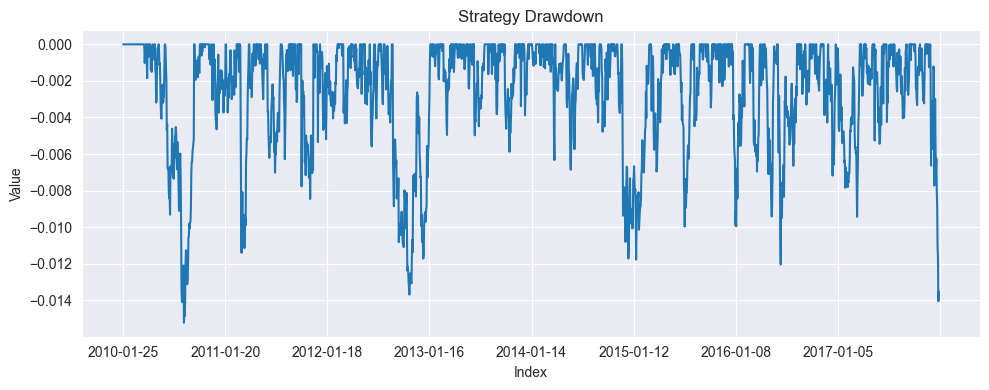

In [21]:
from util_func import *
import matplotlib.pyplot as plt

strategy_ret = pd.read_csv('data/daily_ret.csv').pivot(index=['data_date'], columns='feature', values='ret_post_1')
strategy_turn = pd.read_csv('data/daily_turnover.csv').pivot(index=['data_date'], columns='feature', values='turnover')

dd_ser, dd_summary = calc_drawdown(strategy_ret['strategy'])

dd_ser.plot(kind='line', title='Strategy Drawdown', figsize=(10, 4))
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Draw Down Magnitude and Length is presented as below (historical largest 10 draw down and its length)

In [23]:
#drawdown magnitude and length
dd_summary.sort_values('trough_size', ascending=True).head(10)

,start,end,trough_size,trough_time
7,2010-06-23,2010-10-01,-0.015230,2010-08-26
56,2012-09-06,2013-01-18,-0.013688,2012-11-05
163,2016-06-08,2016-08-12,-0.012042,2016-06-16
126,2014-12-01,2015-03-10,-0.011774,2015-01-21
18,2011-03-15,2011-04-13,-0.011399,2011-03-18
137,2015-06-23,2015-08-05,-0.009967,2015-07-13
155,2015-12-28,2016-02-10,-0.009954,2016-01-11
176,2016-12-29,2017-03-24,-0.009432,2017-03-15
162,2016-04-22,2016-06-03,-0.009412,2016-05-16
37,2011-10-17,2011-11-28,-0.008457,2011-11-15


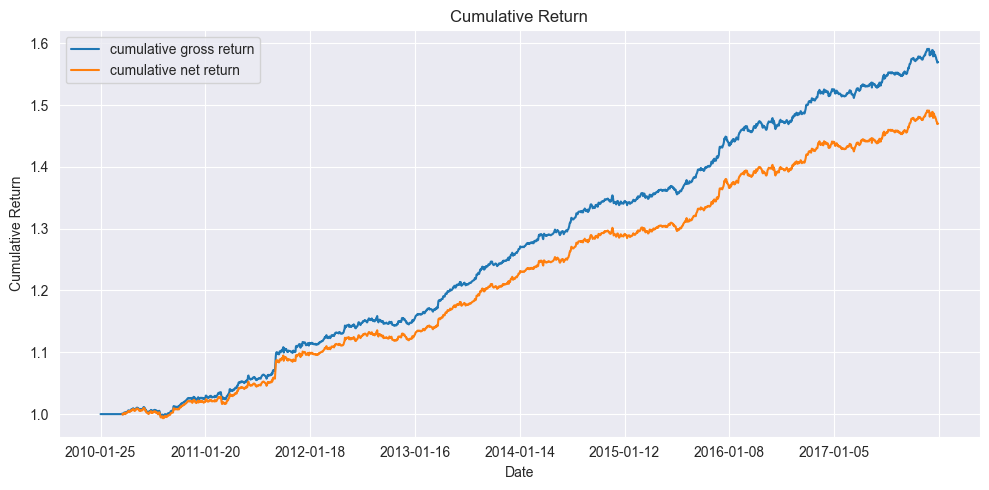

In [22]:
input_df = pd.DataFrame({'gross_ret': strategy_ret['strategy'],
                             'to': strategy_turn['strategy']})
input_df['cost'] = input_df['to'] * 1e-4
input_df['net_ret'] = input_df['gross_ret'] - input_df['cost']
input_df['cumulative gross return'] = (1 + input_df['gross_ret']).cumprod()
input_df['cumulative net return'] = (1 + input_df['net_ret']).cumprod()
df = pd.concat([input_df['cumulative gross return'] , input_df['cumulative net return']], axis=1)
df.plot(kind='line', figsize=(10, 5), title='Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

## ✅ 5. Discussions



